In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

import semd2d_utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events = np.loadtxt(path + "/data/slider_far/events.txt")

In [3]:
# use only the specified patch of input events
patch_center = (90, 90)
patch_size = 180
events = semd2d_utils.filter_patch(events, patch_center, patch_size)

data_steps = 100 # timesteps to divide the data into
sim_steps = 100 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

In [4]:
events_conv, new_shape = flt.filter_conv(events, shape, factor=2)
shape = new_shape
events = events_conv

In [5]:
events = flt.filter_refract(events, 0.5)
events = flt.filter_time(events, 2.5, 2.7)
duration = events[-1, 0] - events[0, 0]

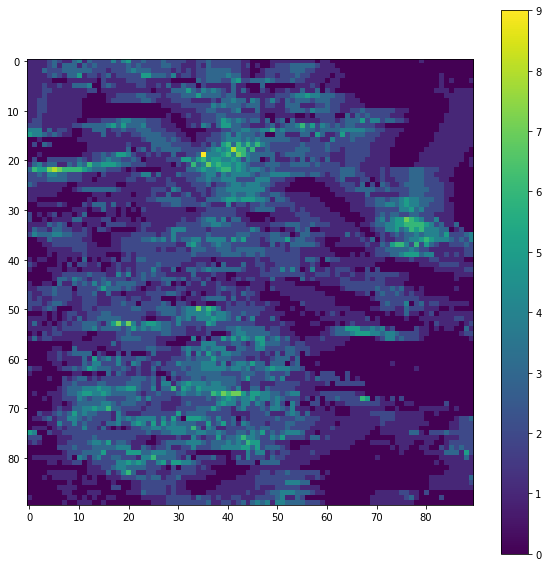

In [6]:
img = vis.events2img(events[:], shape, filter_polarity=False)
plt.figure(figsize=(10, 10))
m = plt.imshow(img, interpolation="none")
plt.colorbar(m)

In [7]:
args = {
    "shape":shape,
    "conv_shape": (1,1),
    "conv_stride": (1,1),
    "thresh_conv": 0.5,
    "detector_du": 0.1,
    "tu": -27.4408245,
    "tv": 0.0
}
data_u, data_v, data_d = semd2d_utils.run_sim(args, events, data_steps, sim_steps)

In [8]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = np.sum(data_u[:,:,0:], axis=-1)
# img_m = np.ma.masked_where(img==0, img)
# m = plt.imshow(img_m, cmap="jet")
# plt.colorbar(m)

In [9]:
# data_m = np.ma.masked_where(data_u==0, data_u)
# plt.hist(data_m.compressed(), 100);

In [10]:
data_u *= (0.2 / sim_steps)
data_v *= (0.2 / sim_steps)

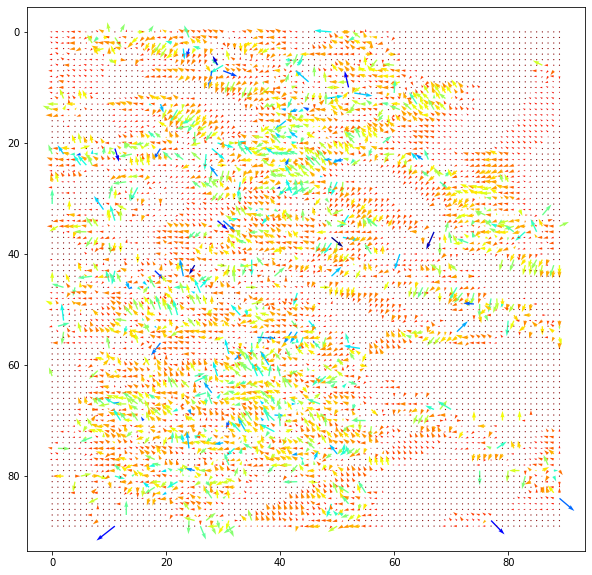

In [11]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(data_u) + np.square(data_v)).sum(axis=-1)
plt.quiver(data_u.sum(axis=-1), data_v.sum(axis=-1), m, cmap="jet_r")
plt.gca().invert_yaxis()

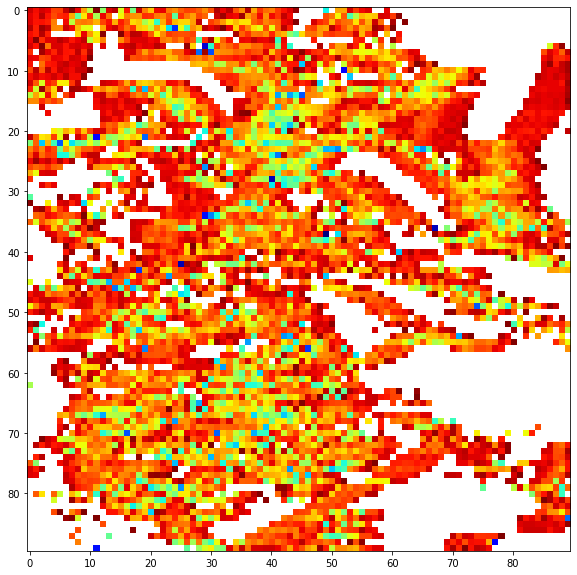

In [12]:
plt.figure(figsize=(10, 10))
m_m = np.ma.masked_where(m==0.0, m)
plt.imshow(m_m, interpolation="none", cmap="jet_r")

In [13]:
# med = flt.median_filter(m_m, 3)
# med_m = np.ma.masked_where(med==0.0, med)
# plt.figure(figsize=(10, 10))
# plt.imshow(med_m, interpolation="none", cmap="jet_r")

In [14]:
d = (data_u.sum(axis=-1) * (-27.28340345) + data_v.sum(axis=-1) * 0.0) * (0.2 / sim_steps)

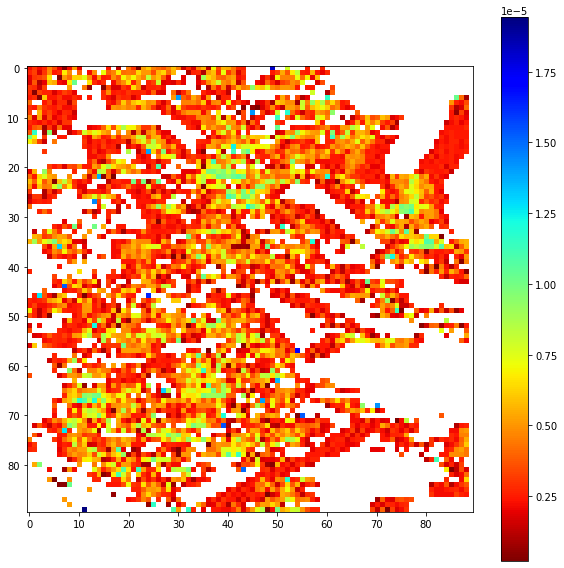

In [15]:
plt.figure(figsize=(10, 10))
d_m = np.ma.masked_where(d <= 0.0, d)
m = plt.imshow(d_m*(duration / sim_steps), interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [42]:
u = np.divide(data_u.sum(axis=-1) , (data_u != 0.0).sum(axis=-1), where=(data_u).sum(axis=-1) != 0.0)
v = np.divide(data_v.sum(axis=-1) , (data_v != 0.0).sum(axis=-1), where=(data_v).sum(axis=-1) != 0.0)
d = (u * (-27.28340345) + v * 0.0)

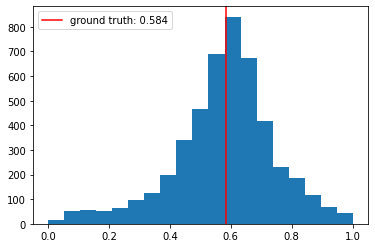

In [63]:
d_m = np.ma.masked_where(d <= 0.0, d)
plt.hist(d_m.compressed(), 19, range=(0.001, 1));
plt.axvline(0.584, c="red", label="ground truth: 0.584")
plt.legend()

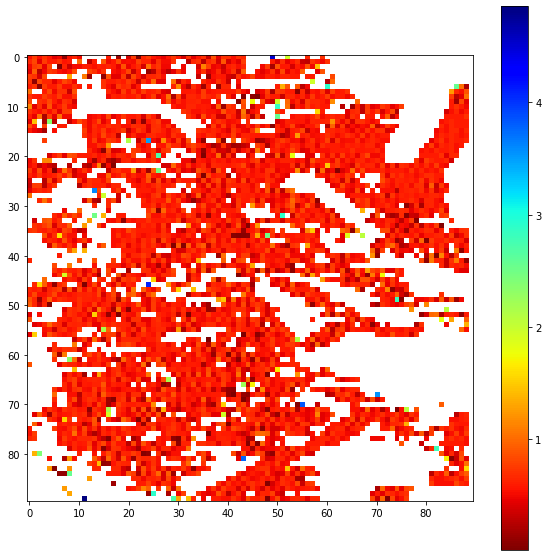

In [44]:
plt.figure(figsize=(10, 10))
m = plt.imshow(d_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

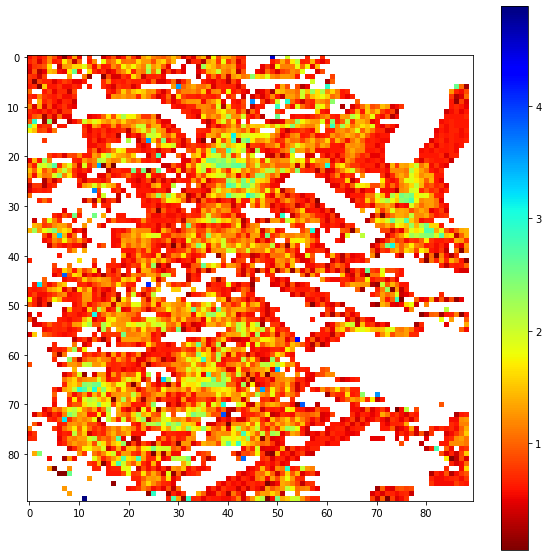

In [55]:
plt.figure(figsize=(10, 10))
data_d_m = np.ma.masked_where(data_d[:,:,:].sum(axis=-1)==0.0, data_d[:,:,:].sum(axis=-1)) * (0.2 / sim_steps)
m = plt.imshow(data_d_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

1.006303706708309


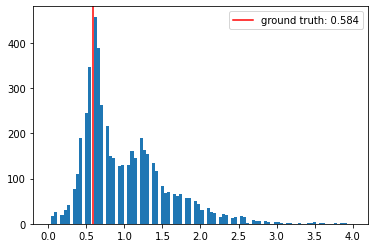

In [58]:
plt.hist(data_d_m.compressed(), 100, range=(0, 4));
# plt.axvline(x=np.ma.mean(data_d_m), c="green", label="mean")
print(np.ma.mean(data_d_m))
plt.axvline(0.584, c="red", label="ground truth: 0.584")
plt.legend()

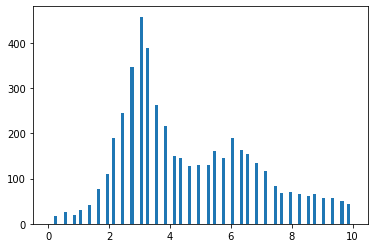

In [57]:
plt.hist(data_d[:,:,:].sum(axis=-1).flatten()*0.01, 100, range=(0.001, 10));

In [22]:
data_d_time = np.zeros((data_d.shape[0], data_d.shape[1]))
for i in range(data_d.shape[-1]):
    data_d_time = np.abs(data_d[:,:,i]*(i+1) + data_d_time * (data_d[:,:,i] == 0).astype(int))

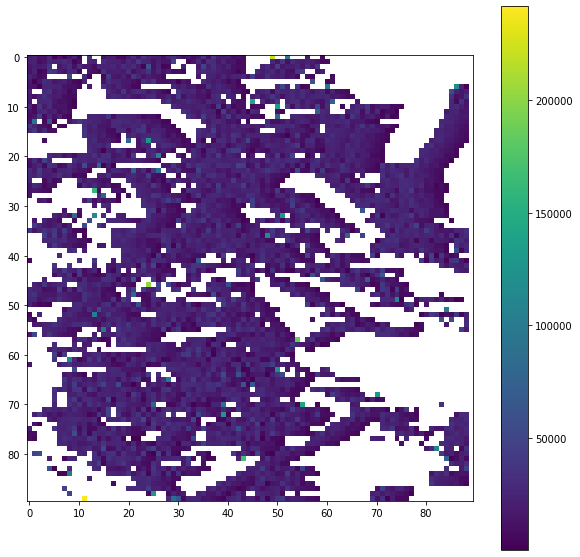

In [23]:
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(data_d_time==0, data_d_time)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(m)

In [24]:
(data_d_time == 0.0).astype(int) * np.full(data_d_time.shape, 2.0)

array([[0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [25]:
data_d.min()

0.0

In [26]:
input_data = semd2d_utils.gen_input_data(events, shape, 100)

In [27]:
input_data.shape

(90, 90, 100)

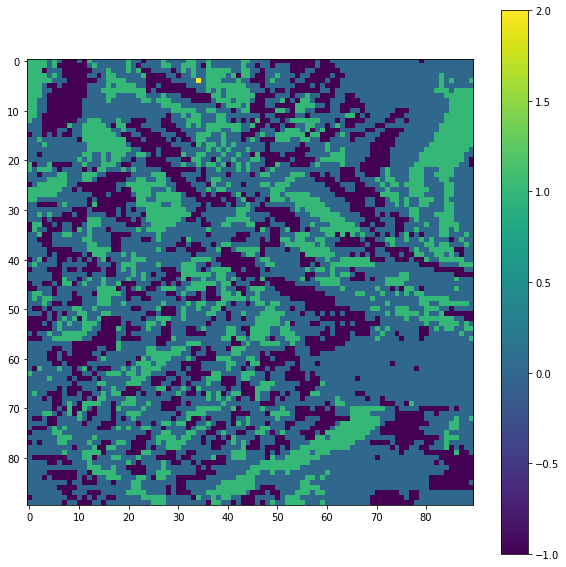

In [28]:
plt.figure(figsize=(10, 10))
m = plt.imshow(input_data.sum(axis=-1), interpolation="none")
plt.colorbar(m)

In [29]:
input_data_time = np.zeros((input_data.shape[0], input_data.shape[1]))
for i in range(input_data.shape[-1]):
    input_data_time = np.abs(input_data[:,:,i]*(i+1) + input_data_time * (input_data[:,:,i] == 0).astype(int))

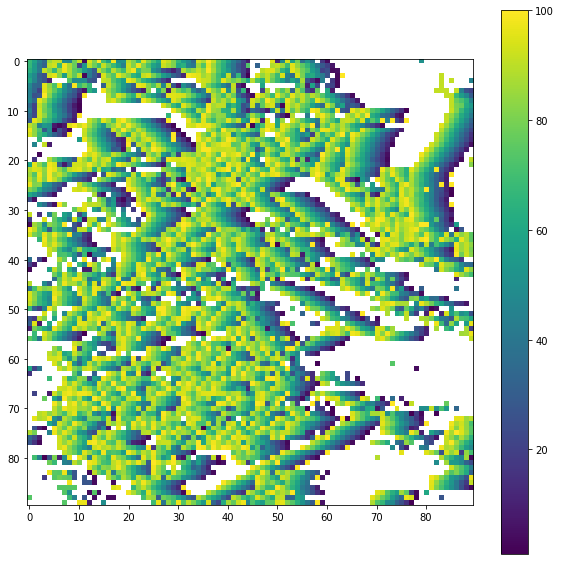

In [30]:
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(input_data_time==0, input_data_time)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(m)

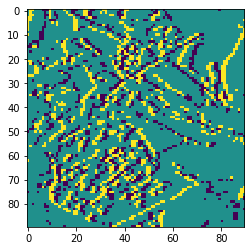

In [31]:
plt.imshow(input_data[:,:,40:60].sum(axis=-1), interpolation="none")

In [64]:
d = d_m

gt_d = 0.584

mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

print(np.ma.mean(d))

0.15719834221565632
0.09289873789999986
0.6128385053827599
